In [252]:
# Module import
from IPython.display import Image
import sys
import pandas as pd

# To use interact -- IPython widget
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


# append to path the folder that contains the analytic scanner
sys.path.append('../GaiaLab/scan/analytic_scanner')
# local imports
#from gaia_analytic_toymodel import *

from scipy import interpolate
import timeit

import frame_transformations as ft
from scanner import Scanner
from satellite import Satellite
from source import Source

import constants as const

from quaternion import Quaternion
from agis import Agis
from agis import Calc_source
from agis_functions import *

from analytic_plots import *

# Ipython magics
%load_ext autoreload
%autoreload 2
# %matplotlib notebook 
# %matplotlib widget
# %matplotlib ipympl

# Set some user-specific variables
# MAIN_FOLDER = '../' # relative path to project folder
# FIG_FOLDER = 'figures/' # relative path to figure

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# functions definitions:

In [253]:
def error_in_attitude(my_times, Solver, gaia):
    error_in_attitude = 0
    for t in my_times:
        agis_att = Solver.get_attitude(t)
        gaia_att = gaia.func_attitude(t)
        diff_att_w = gaia_att.w - agis_att.w
        error_in_attitude += diff_att.compute_magnitude()
    return error_in_attitude

def error_between_func_attitudes(my_times, func_att1, func_att2):
    error_in_attitude = 0
    for t in my_times:
        diff_att = 0
        att1 = func_att1(t) 
        att2 = func_att2(t)
        diff_att += np.abs(att2.w - att1.w)
        diff_att += np.abs(att2.x - att1.x)
        diff_att += np.abs(att2.y - att1.y)
        diff_att += np.abs(att2.z - att1.z)
        error_in_attitude += np.abs(diff_att)
    return error_in_attitude
    

# Initializing objects:

In [272]:
# # create all the objects we will need:
# parameters for the notebook
t_init = 1/24/60
t_end = t_init + 1/24 # 365*5
my_dt = 1/24/20# [days]

spline_order = 3  # actually it is the spline degree
gaia = Satellite(ti=t_init, tf=t_end, dt= my_dt, k=spline_order)
print('Sat created')
my_times = np.linspace(t_init, t_end, num=100, endpoint=False)
real_sources = []
calc_sources = []
for t in my_times:
    alpha, delta = generate_observation_wrt_attitude(gaia.func_attitude(t))
    real_src_tmp = Source(str(t),np.degrees(alpha), np.degrees(delta), 0, 0, 0, 0)
    calc_src_tmp = Calc_source('calc_'+str(t), [t], real_src_tmp.get_parameters()[0:5], real_src_tmp.get_parameters()[5])
    real_sources.append(real_src_tmp)
    calc_sources.append(calc_src_tmp)
print('Sources created!')

Sat created
Sources created!


len(real_sources):  100


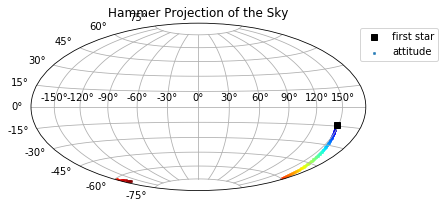

In [267]:
fig = plt.figure()
plt.subplot(111, projection="hammer")
alphas = []
deltas = []
#print('my_times: ', my_times)
print('len(real_sources): ', len(real_sources))
for i, s in enumerate(real_sources):
    alpha, delta = s.alpha-np.pi, s.delta
    #print(i, alpha, delta)
    alphas.append(alpha)
    deltas.append(delta)
    if i==0:
        plt.plot(alpha, delta, 'sk', label='first star')
    else:
        # plt.plot( alpha, delta,',')
        pass
plt.scatter(alphas, deltas, c=my_times, marker='s', s=(72./fig.dpi)**2, cmap='jet', alpha=0.8,
               label='attitude', lw=2)

plt.title("Hammer Projection of the Sky")
plt.legend(loc=9, bbox_to_anchor=(1.1, 1))
plt.grid(True)

In [268]:
# test if source and calc source are equal (as they should be)
np.testing.assert_array_almost_equal(np.array(real_sources[0].get_parameters()[0:5]), calc_sources[0].s_params)

In [269]:
# create Solver
Solver = Agis(gaia, calc_sources, real_sources, attitude_splines=[gaia.s_w, gaia.s_x, gaia.s_y, gaia.s_z], spline_order=spline_order,
             attitude_regularisation_factor=1e-0)

## Tests:

In [243]:
Solver.actualise_splines()
Solver.set_splines_basis()
print('Error before Noise: ', Solver.error_function())
print('Errors after noise of attitude (not representatif):', error_between_func_attitudes(my_times, gaia.func_attitude, Solver.get_attitude))
c_noise = Solver.att_coeffs * np.random.rand(Solver.att_coeffs.shape[0], Solver.att_coeffs.shape[1]) * 1e-6
print('c_noise shape: ', c_noise.shape)
Solver.att_coeffs = Solver.att_coeffs + c_noise
Solver.actualise_splines()
#Solver.set_splines_basis()
print('Error after Noise: ', Solver.error_function())
print('Errors after noise of attitude (not representatif):', error_between_func_attitudes(my_times, gaia.func_attitude, Solver.get_attitude))

Error before Noise:  288.38045314761894
Errors after noise of attitude (not representatif): 227.00737343002044
c_noise shape:  (4, 21)
Error after Noise:  288.38045873920885
Errors after noise of attitude (not representatif): 227.00737233143053


(21, 50)
0.0006944444444444444 to 0.041527777777777775


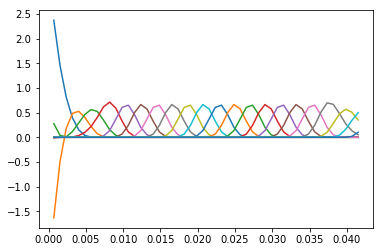

In [104]:
basis = get_basis_Bsplines(knots=Solver.att_knots[0,:], coeffs=Solver.att_coeffs[0,:], k=Solver.k, obs_times=my_times)
for b in basis:
    plt.plot(my_times, b)
print(basis.shape)
print(my_times[0], 'to', my_times[-1])

In [12]:
# given the spline: 
m = 10 # [0-100]
M = 4
knots = Solver.att_knots[0]
coeffs = Solver.att_coeffs[0]
bases = Solver.att_bases[0]

observed_times = Solver.all_obs_times[(knots[m]<=Solver.all_obs_times) & (Solver.all_obs_times<=knots[m+M]) ]
print(observed_times[0])
if not list(observed_times):
    raise ValueError('not observed times in interval')

t = observed_times[0]
index = np.where(Solver.all_obs_times==t)[0][0]

tau_l = np.where(knots<=t)
# print('tau_l: ',tau_l)
if not list(tau_l[0]):
    L1=0
    L = L1
else:
    L1=tau_l[0][-1]
    L = L1
    if L-M>=0:
        L=L-M
print('t:', t)
print('left_index: ',get_left_index(Solver.att_knots[0], t, M))
print('L, L1:', L, L1)
print('M: ',M)
b_list = []
N = len(coeffs)
for i, n in enumerate(range(L, L+M+1)): # last +1 because range does not inlude the last point
    print(i)
    coeff = coeffs[n]
    bspline = bases[n]
    b_list.append(coeff*bspline)
d = compute_coeff_basis_sum(Solver.att_coeffs, Solver.att_bases, L1, M, index)
# d = np.sum(Solver.att_bases[:, L1-M:L1+1, index] * Solver.att_coeffs[:, L1-M:L1+1], axis=1)
# d = compute_attitude_deviation(coeff_basis_sum)
print(Solver.att_bases[:, L:L+M, :].shape)
print(Solver.att_coeffs[:, L:L+M].reshape(4, -1, 1).shape)
print((Solver.att_bases[:, L:L+M, :] * Solver.att_coeffs[:, L:L+M].reshape(4, -1, 1)).shape)
# c = sum((Solver.att_bases[:, L:L+M, :].transpose(0,2,1) * coeffs[L:L+M]).transpose(0,2,1))
c = np.sum(Solver.att_bases[:, L1-M:L1+1, index] * Solver.att_coeffs[:, L1-M:L1+1], axis=1)[0]
b = sum(b_list)
a = sum([coeff*bspline for coeff, bspline in zip(Solver.att_coeffs[0], Solver.att_bases[0])])
print('man4al: ', d[0])
print('man3al: ', c)
print('man2al: ', b[index])
print('manual: ', a[index])
print('artifi: ', BSpline(Solver.att_knots[0], Solver.att_coeffs[0], k=3)(t))

0.004861111111111111
t: 0.004861111111111111
left_index:  11
L, L1: 7 11
M:  4
0
1
2
3
4
(4, 4, 20)
(4, 4, 1)
(4, 4, 20)
man4al:  0.8094960643087932
man3al:  0.8094960643087932
man2al:  0.8094960643087932
manual:  0.8094960643087932
artifi:  0.8094960643087932


In [13]:
Solver.att_bases[0, 0:2, 0]

array([ 1.58796296, -0.64866255])

In [16]:
for i in range(Solver.att_coeffs.shape[1]):
    Solver.att_coeffs[:,i] /= np.linalg.norm(Solver.att_coeffs[:,i])

In [22]:
Solver.reset_iterations()

In [239]:
Solver.verbose=False
Solver.reset_iterations()
Solver.iterate(1)

***** Iteration: 1 *****
21
193883.2798746298
Error after iteration: 288.38045314761894


In [240]:
Solver.get_attitude(0.005).magnitude

2.2543577158720924

In [189]:
Solver.iterate(3)

***** Iteration: 8 *****
21
188604.0859612995
Error after iteration: 257.288461886943
***** Iteration: 9 *****
21
300001.1435120179
Error after iteration: 230.0611198138634
***** Iteration: 10 *****
21
464411.4057996629
Error after iteration: 215.47746186175866


In [270]:
N_aa = Solver.compute_attitude_LHS()
print('N_aa computed')
h = Solver.compute_attitude_RHS()
print('shape of h: ', h.shape)
print('h/4: ', h.shape[0]/4)

21
N_aa computed
shape of h:  (84, 1)
h/4:  21.0


In [271]:
print('my_times shape:', my_times.shape)
print('coeffs shape:',Solver.att_coeffs.shape)
print('Matrix dimension: ', N_aa.shape)
print('Is the matrix symmetric? ', helpers.check_symmetry(N_aa))
eig_vals, eig_vecs = np.linalg.eigh(N_aa)
print('Condition number: ', np.linalg.cond(N_aa))
print('min-max eig_vals: ',eig_vals.min(), eig_vals.max())
print('Condition number (eig_max/eig_min): ', np.abs(eig_vals.max())/np.abs(eig_vals.min()))
print('Rank: ', np.linalg.matrix_rank(N_aa, hermitian=True))
print('det(N_aa):', np.linalg.det(N_aa))
print('smallest eig_vals: ', np.sort(eig_vals)[0:5])
print('biggest eigenvalues: ', eig_vals[-10:-1])
print('eig_vals product: ', np.prod(eig_vals))
print('my_times shape:', my_times.shape)
print('coeffs shape:',Solver.att_coeffs.shape)
print('det(N_aa):', np.linalg.det(N_aa))
print('eigenvalues: ', eig_vals[0])
print('N_aa:', N_aa)

my_times shape: (100,)
coeffs shape: (4, 21)
Matrix dimension:  (84, 84)
Is the matrix symmetric?  True
Condition number:  2.4797407972403382e+17
min-max eig_vals:  -1.4394778914217138e-15 40.4788104709016
Condition number (eig_max/eig_min):  2.8120480843872028e+16
Rank:  78
det(N_aa): 2.1833134028226285e-249
smallest eig_vals:  [-1.43947789e-15 -1.00475149e-15 -8.25908806e-16  5.17887541e-16
  1.01884446e-15]
biggest eigenvalues:  [20.11470679 20.23899337 22.09476321 25.55832374 29.24057895 32.78785236
 35.89712292 38.30545532 40.22841382]
eig_vals product:  -3.4755690265175277e-246
my_times shape: (100,)
coeffs shape: (4, 21)
det(N_aa): 2.1833134028226285e-249
eigenvalues:  -1.4394778914217138e-15
N_aa: [[ 3.89623125 -2.24383712 -1.53998205 ...  0.          0.
   0.        ]
 [-2.24383712  1.35699799  0.16498756 ...  0.          0.
   0.        ]
 [-1.53998205  0.16498756  8.69610432 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.34931717  0.3502

In [113]:
Solver.att_coeffs.shape

(4, 11)

In [273]:
print(Solver.compute_Naa_mn(0,1))
print(Solver.compute_Naa_mn(8,9))
print(Solver.compute_Naa_mn(9,10))

[[ 2.63450506 -1.52433051 -1.02359539  0.03550404]
 [-1.52433051  0.91942218  0.14223677  0.09010248]
 [-1.02359539  0.14223677  5.87919518 -1.36214994]
 [ 0.03550404  0.09010248 -1.36214994  0.33237421]]
[[ 3.6244303  -2.33623236 -0.56096802  0.71727048]
 [-2.33623236  1.70921167  1.63094441 -0.78014501]
 [-0.56096802  1.63094441  8.06126887 -2.10592218]
 [ 0.71727048 -0.78014501 -2.10592218  0.64156747]]
[[ 3.58491089 -2.32733329 -0.44470231  0.79438086]
 [-2.32733329  1.79878893  1.7949365  -0.89630975]
 [-0.44470231  1.7949365   7.971606   -2.09738556]
 [ 0.79438086 -0.89630975 -2.09738556  0.68129889]]


my_times shape: (100,)
coeffs shape: (4, 11)
det(N_aa): -4.2528982427444296e-265
eigenvalues:  [-3.10749999e-15  2.40301297e-16  1.03868570e-15  1.53920366e-14
  1.55323780e-13  7.86824913e-13  3.52040709e-12  8.57972354e-12
  2.14297056e-11  4.57980278e-11  1.88124867e-10  4.90063751e-10
  2.16495821e-09  1.76316450e-08  3.85253198e-08  5.28167059e-08
  9.63503447e-08  1.51600644e-07  1.88540072e-07  2.88646937e-07
  5.43657113e-07  6.28831692e-07  9.00037646e-07  1.22501782e-06
  1.66059036e-06  2.00422886e-06  2.40769939e-06  3.19759861e-06
  3.72234539e-06  3.88274403e-06  1.13753100e-05  3.02395649e-05
  5.70632744e-05  1.00498738e+00  1.36916147e+00  4.61502644e+00
  6.99909358e+00  1.30241407e+01  1.99309076e+01  2.79005418e+01
  4.05887199e+01  5.03249998e+01  7.42810668e+01  8.72945139e+01]


-2.876074531468922e-264

In [34]:
print(Solver.att_coeffs.shape)
print(Solver.att_knots.shape)
print(Solver.M)

(4, 17)
(4, 21)
4


In [36]:
if np.linalg.det(N_aa) > 0:
    L = np.linalg.cholesky(N_aa)
    print(L)
else: 
    print('Determinant of N_aa not positive')
np.linalg.solve(N_aa, h)[0:5]

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


array([[-0.00250713],
       [ 0.00074355],
       [-0.00196342],
       [-0.00157021],
       [-0.00220787]])

In [36]:
N_aa_dim = Solver.att_coeffs.shape[1]
RHS = np.zeros((N_aa_dim*4, 1))
for n in range(0, N_aa_dim):
    RHS[n*4:n*4+4] = Solver.compute_attitude_RHS_n(n)
print(RHS.shape)

(68, 1)


In [37]:
rhs = np.zeros((4, 1))
n_index = 4
observed_times = get_times_in_knot_interval(Solver.all_obs_times, Solver.att_knots[0], n_index, Solver.M)
for i, t_L in enumerate(observed_times):
    source_index = Solver.get_source_index(t_L)
    calc_source = Solver.calc_sources[source_index]
    attitude = Solver.get_attitude(t_L)
    left_index = get_left_index(Solver.att_knots[0], t_L, M=Solver.M)
    obs_time_index = list(Solver.all_obs_times).index(t_L)

    # Compute the regulation part
    coeff_basis_sum = compute_coeff_basis_sum(Solver.att_coeffs, Solver.att_bases,
                                              left_index, Solver.M, obs_time_index)
    D_L = compute_attitude_deviation(coeff_basis_sum)
    dDL_da_n = compute_DL_da_i(coeff_basis_sum, Solver.att_bases, obs_time_index, n_index)
    regulation_part = Solver.attitude_regularisation_factor**2 * dDL_da_n * D_L

    # # WARNING: Here we put the Across scan and the along scan together
    dR_dq = compute_dR_dq(calc_source, Solver.sat, attitude, t_L)
    dR_da_n = dR_da_i(dR_dq, Solver.att_bases[:, n_index, obs_time_index])
    R_L = Solver.compute_attitude_R_L(source_index, attitude, t_L)
    rhs += dR_da_n * R_L + regulation_part.reshape(4,-1)
    print(regulation_part)
    #print(dR_da_n * R_L)
print(rhs)

AttributeError: 'Agis' object has no attribute 'compute_attitude_R_L'

In [38]:
dR_dq = compute_dR_dq(Solver.calc_sources[0], Solver.sat, Solver.get_attitude(t), )
dR_da_i(dR_dq, Solver.att_bases[:, n_index, obs_time_index])

TypeError: compute_dR_dq() missing 1 required positional argument: 't'

In [39]:
print(h)

[[   1.84915048]
 [  -3.80287831]
 [ -14.85711093]
 [  -5.20756582]
 [   3.39345468]
 [  -6.6828352 ]
 [ -24.69252675]
 [  -8.29540965]
 [   5.59254533]
 [  -9.97101641]
 [ -35.10255587]
 [ -10.8659821 ]
 [   9.17415464]
 [ -13.63843397]
 [ -47.44340502]
 [ -12.69861214]
 [  10.19051143]
 [ -11.2204245 ]
 [ -41.74926273]
 [  -8.68751371]
 [  13.52264371]
 [ -10.33202305]
 [ -45.49096167]
 [  -6.99000326]
 [  17.93836267]
 [  -8.07516253]
 [ -49.95435412]
 [  -5.16181038]
 [  23.70283658]
 [  -4.11429159]
 [ -55.32140512]
 [  -3.63900321]
 [  31.0702819 ]
 [   1.78885434]
 [ -61.70708913]
 [  -3.08313831]
 [  40.19454946]
 [   9.61649745]
 [ -69.06965256]
 [  -4.375115  ]
 [  50.98001102]
 [  18.88157195]
 [ -77.09182764]
 [  -8.47986547]
 [  62.90474345]
 [  28.45950187]
 [ -85.08306947]
 [ -16.10331307]
 [  74.9349977 ]
 [  36.66787618]
 [ -92.0168009 ]
 [ -27.183845  ]
 [ 108.79304032]
 [  52.29222068]
 [-121.11018691]
 [ -53.73921768]
 [  88.89071957]
 [  39.88947337]
 [ -92.6827232

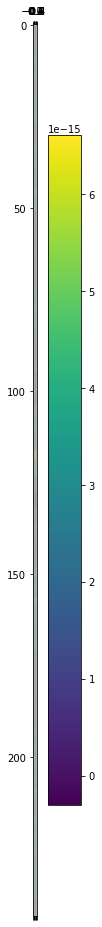

In [102]:
plt.matshow(h, fignum=None)
plt.colorbar()
plt.grid()
plt.show()

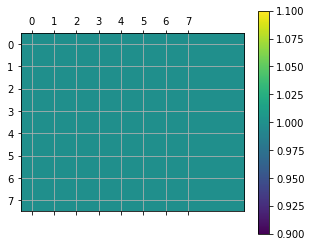

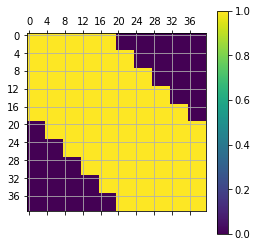

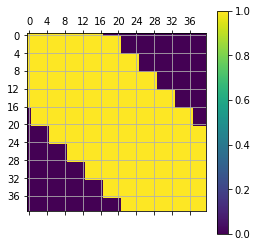

In [21]:
helpers.plot_sparsity_pattern(N_aa[10:18, 0:10], 1)
helpers.plot_sparsity_pattern(N_aa[0:40, 0:40], 4)
helpers.plot_sparsity_pattern(N_aa[-41:-1, -41:-1], 4)

25
source index: 3
source index: 6
source index: 5
source index: 4
source index: 3
source index: 6
source index: 7
source index: 4
source index: 5
source index: 8
source index: 3
source index: 6
source index: 7
source index: 4
source index: 5
source index: 8
source index: 9
source index: 10
source index: 3
source index: 6
source index: 7
source index: 4
source index: 5
source index: 8
source index: 9
source index: 10
source index: 11
source index: 12
source index: 7
source index: 9
source index: 11
source index: 10
source index: 8
source index: 12
source index: 13
source index: 14
source index: 9
source index: 12
source index: 11
source index: 10
source index: 13
source index: 14
source index: 15
source index: 16
source index: 11
source index: 12
source index: 14
source index: 15
source index: 13
source index: 16
source index: 17
source index: 18
source index: 13
source index: 14
source index: 17
source index: 16
source index: 15
source index: 18
source index: 19
source index: 20
sourc

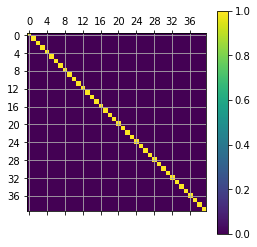

0.0


In [42]:
N_aa = Solver.compute_attitude_LHS()
tol = 1
A = N_aa[0:40, 0:40]
B = A #np.zeros(A.shape)
# B[np.where( np.abs(A) > tol)] = 1
plt.matshow(B, fignum=None)
plt.colorbar()
plt.xticks(np.arange(0, B.shape[0], 4))
plt.yticks(np.arange(0, B.shape[0], 4))
plt.grid()
plt.show()
print(N_aa.min())

min_of_A: 0.0
min of A:  1.0


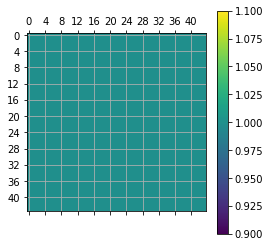

In [44]:
A = N_aa.copy()[0:44,0:44]
my_min = np.amin(A)
print('min_of_A:', my_min)
threshold = A.min()
A[np.where(A==threshold)] = A.max()
print('min of A: ',A.min())
plt.matshow(A, fignum=None)
plt.colorbar()
plt.xticks(np.arange(0, A.shape[0], 4))
plt.yticks(np.arange(0, A.shape[0], 4))
plt.grid()
plt.show()

In [24]:
print(len(my_times))
Solver.att_bases.shape

100


(4, 11, 100)

In [100]:
Solver.M

4

In [101]:
a = 2
print(a)

2
